# Advanced Lane Finding Project

In this project, The goal is to write a software pipeline to identify the lane boundaries in a video from a front-facing camera on a car. 

The steps involved inthe pipeline are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

The pipeline will be build progressively. 


---
## Import libraries

In [30]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

## Camera Calibration
The goal of camera calibration is to compute the distortion of the image induced when the camera transforms a 3D object into a 2D image. The transformation is in general imperfect and distortion will change the shape and size of the objects. Once the distortion parameters of the camera are know, when can use them to inverse the distortion and recover correct information on the object. 

To compute the distortion, we need to 
* convert the image to grayscale,  
* use the function `cv2.findChessboardCorners` to automatically detect the corners
* use the `cv2.calibrateCamera` function
* apply the `cv2.undistort` function with parameters computed by the previous function to correct distortion in the following image.


In [76]:
def grayscale(im):
    return cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)


def plot_image(im):
    plt.figure()
    plt.imshow(im)
    plt.show()
    return


def plot_2_images(im1, im2, title1='Original Image', title2='Modified Image'):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(im1)
    ax1.set_title(title1, fontsize=50)
    ax2.imshow(im2)
    ax2.set_title(title2, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()
    return


def plot_chessboard(img, ret, corners):
    # Draw and display the corners
    img = cv2.drawChessboardCorners(img, (9, 6), corners, ret)
    plot_image(img)
    return


def calibrate_chessboard(img, obj_points, img_points, plot=False):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6 * 9, 3), np.float32)
    objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

    gray = grayscale(img)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
    # If found, add object points, image points
    if ret:
        obj_points.append(objp)
        img_points.append(corners)
        if plot:
            plot_chessboard(img, ret, corners)

    return objpoints, imgpoints


def calibrate_multiple_chessboards(imglist):
    """
    Compute point correspondence on a list of images
    :param filelist: list of chessboard images
    :return: objpoints, imgpoints : two list with the correspondance between real space and image space.
    """
    # initialize object points and image points
    objpoints = []
    imgpoints = []

    # Step through the list and search for chessboard corners
    for fname in imglist:
        image = cv2.imread(fname)
        objpoints, imgpoints = calibrate_chessboard(image, objpoints, imgpoints)
    return objpoints, imgpoints, image.shape[:2]


def calibrate_camera(filelist):
    """
    calibrate camera using several picture taken with the camera.
    :param filelist: 
    :return: mtx : camera matrix, dist : distortion parameters 
    """
    # compute object/image points correspondence
    objpoints, imgpoints, shape = calibrate_multiple_chessboards(filelist)
    # Calibrate camera
    _, mtx, dist, _, _ = cv2.calibrateCamera(objpoints, imgpoints, shape[::-1], None, None)

    return mtx, dist


def undistort_image(img, M, dist):
    dst = cv2.undistort(img, mtx, dist, None, mtx)

    return dst

Now, we can these the calibration on some test images.

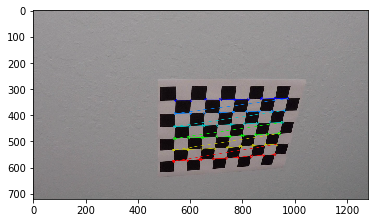

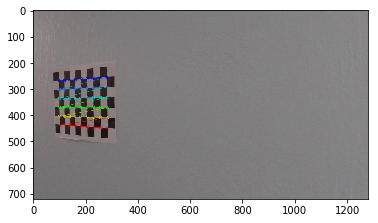

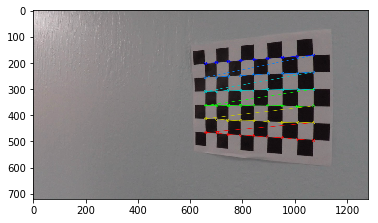

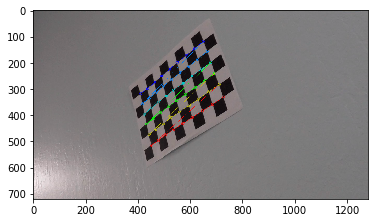

In [58]:
# initialize object points and image points
objpoints = []
imgpoints = []

# Make a list of calibration images
images = glob.glob('./CarND-Advanced-Lane-Lines-P4/camera_cal/calibration*.jpg')
# Step through the list and search for chessboard corners
for fname in images[:5]:
    image = cv2.imread(fname)
    objpoints, imgpoints = calibrate_chessboard(image, objpoints, imgpoints, plot = True)

Note that for some reason, the `cv2.findChessboardCorners` functions fails for image 'calibration1.jpg'. For all other images, it seems to find the corners correctly. We can also compute the distortion parameters of the camera :

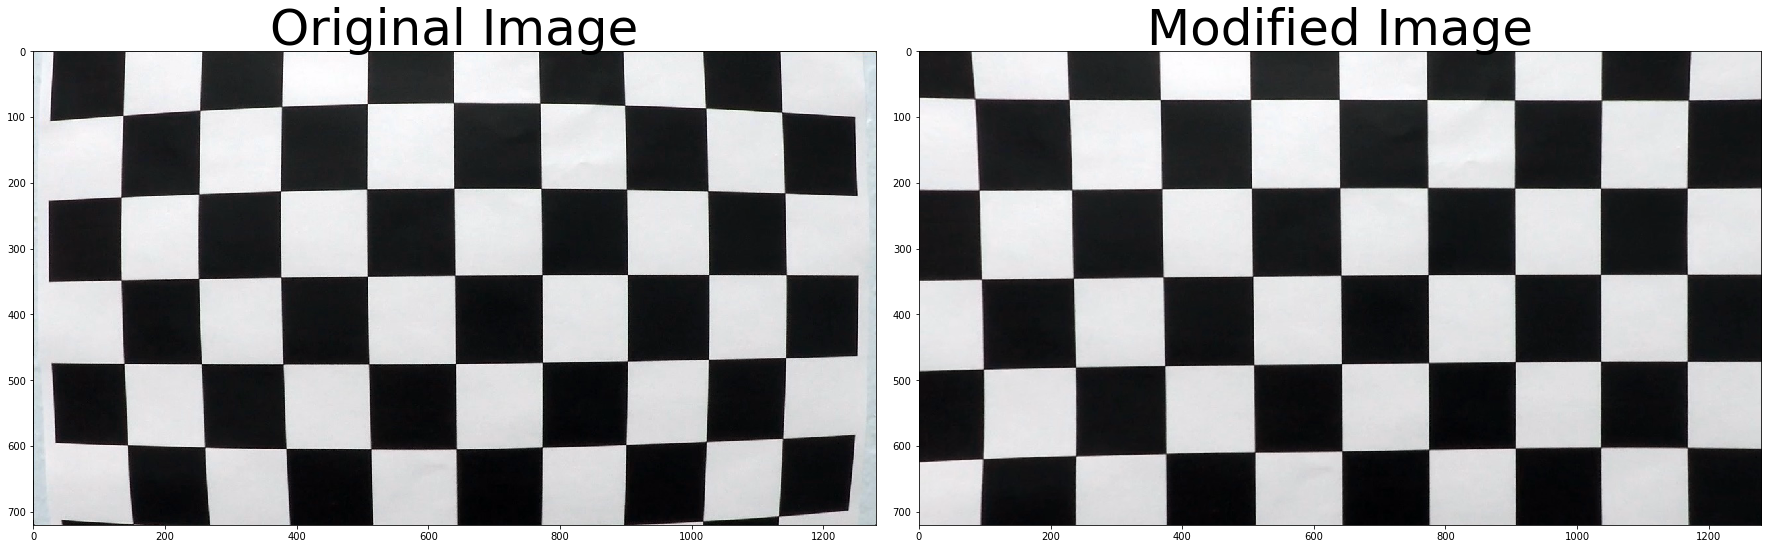

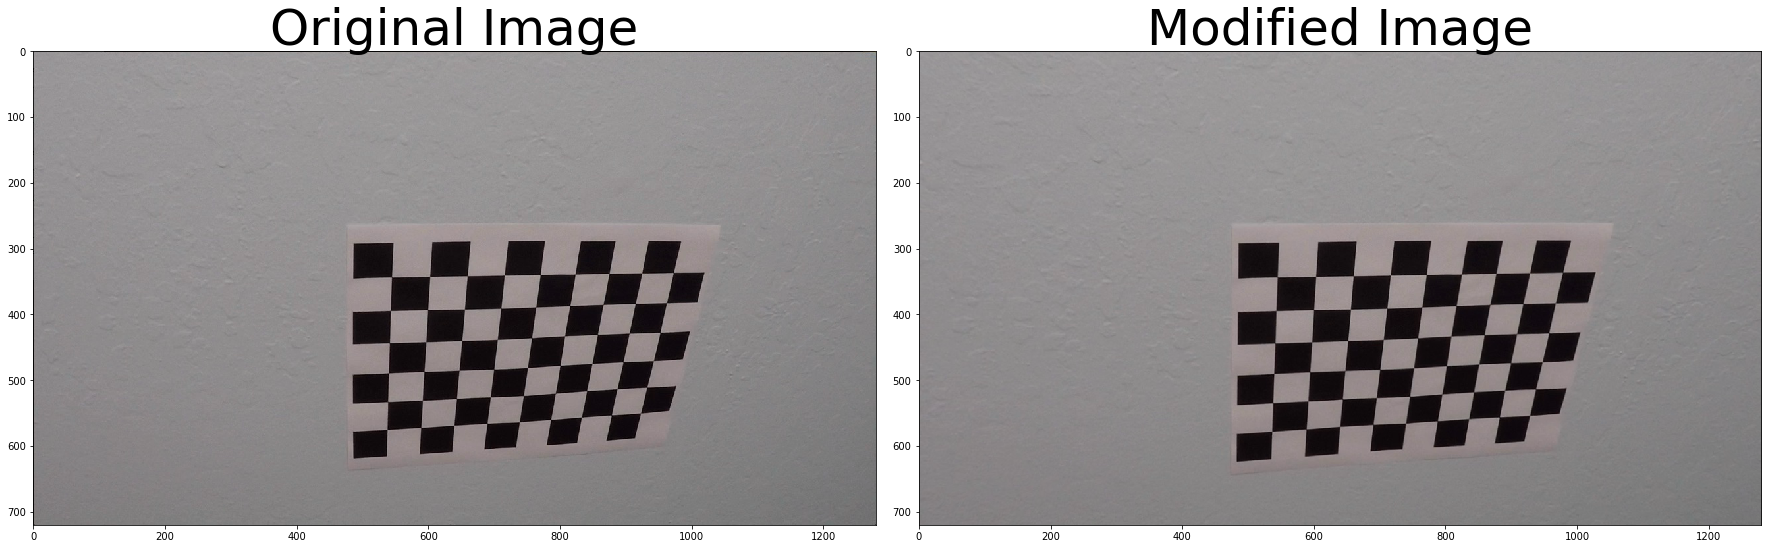

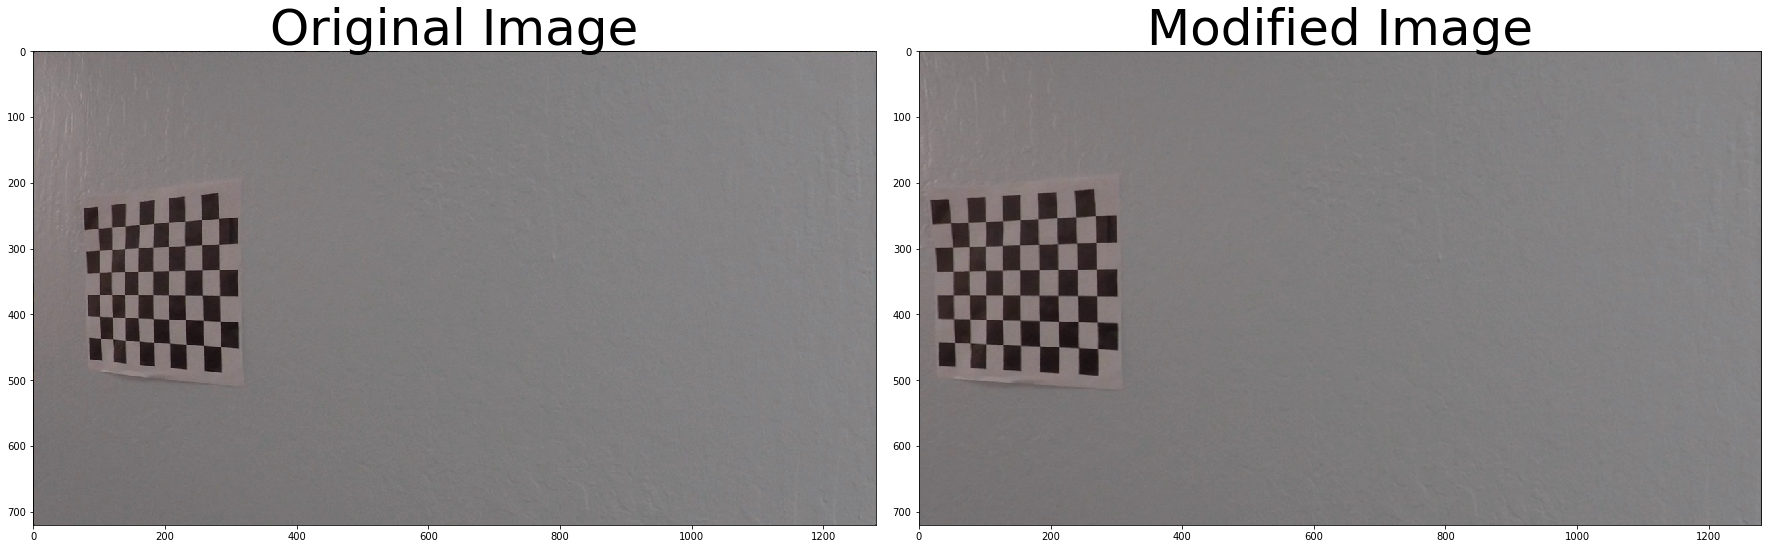

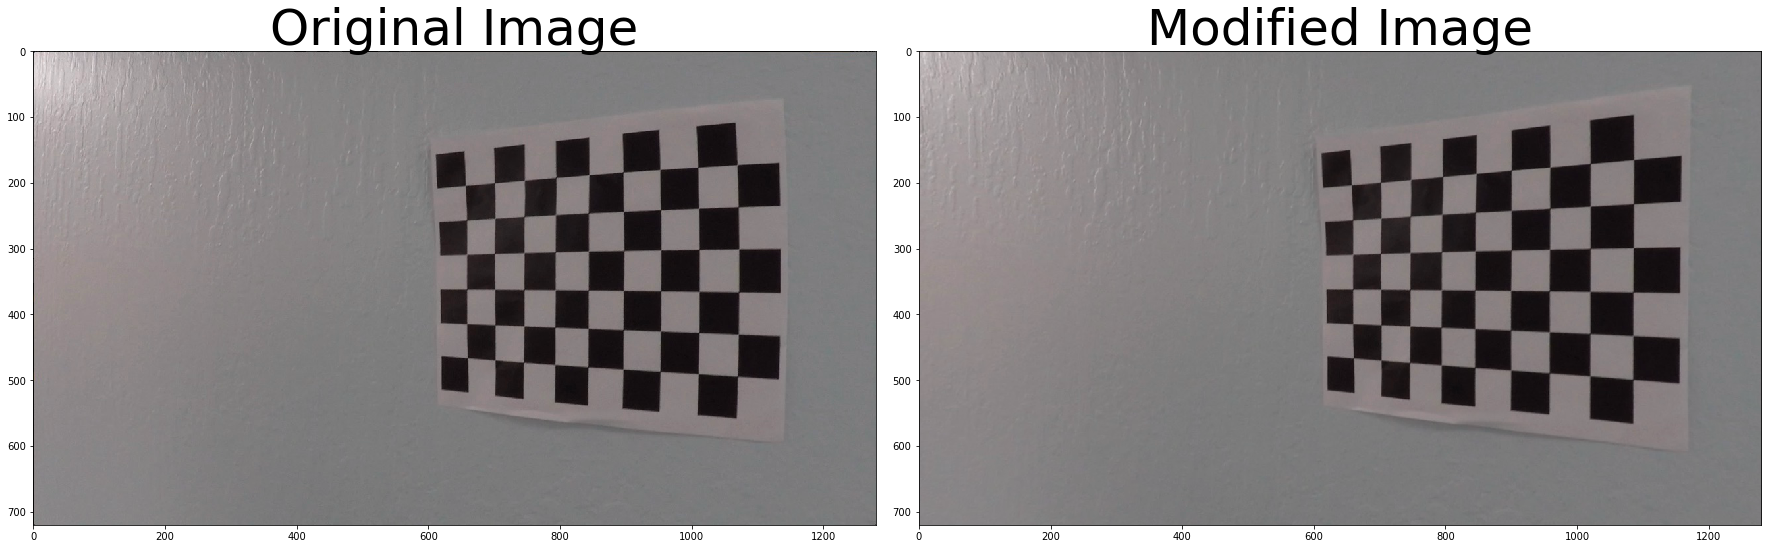

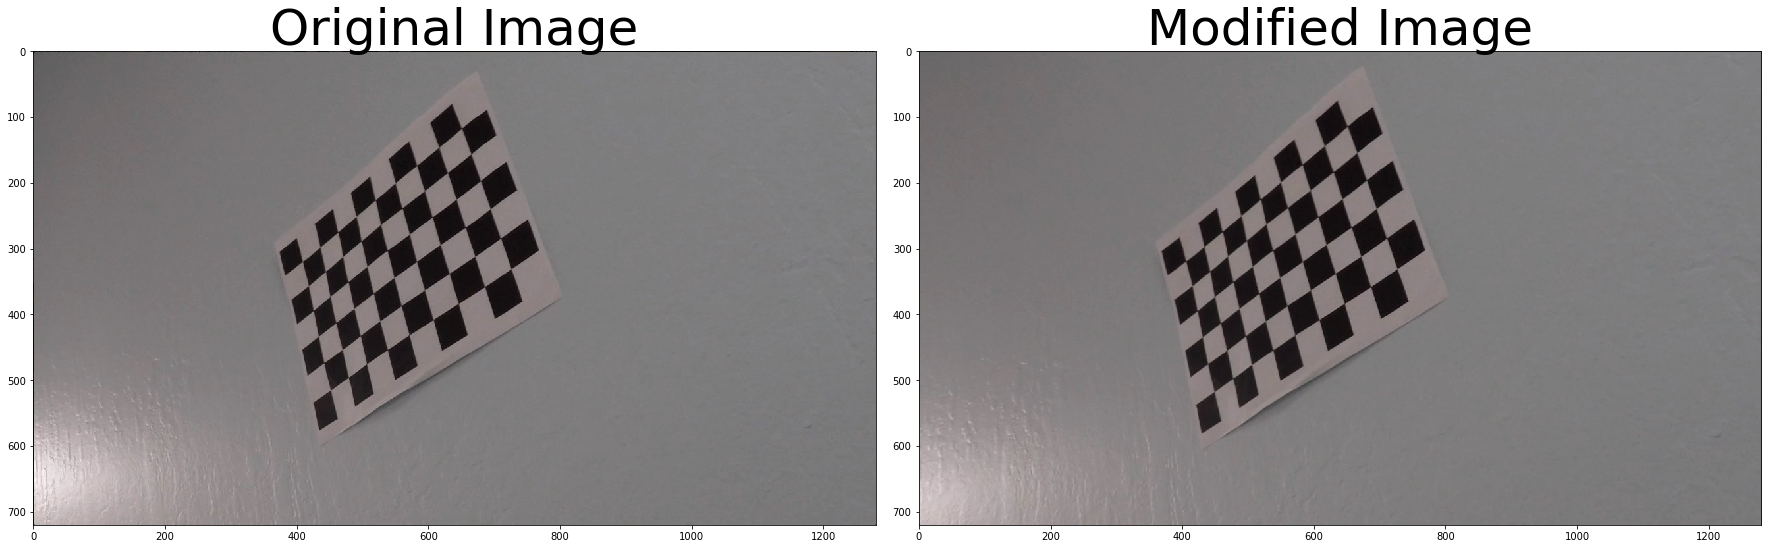

In [77]:
# Make a list of calibration images
images = glob.glob('./CarND-Advanced-Lane-Lines-P4/camera_cal/calibration*.jpg')
m, dist = calibrate_camera(images)
# Step through the list and search for chessboard corners
for fname in images[:5]:
    image = cv2.imread(fname)
    undist = undistort_image(image, m, dist)
    plot_2_images(image, undist)